In [48]:
import time

import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
from scipy.signal import fftconvolve

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

from src.cartm.model import ContextTopicModel

In [113]:
data = fetch_20newsgroups(data_home='./data/', subset='all').data
df = pd.DataFrame(data, columns=['text'])
df

,text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...
...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...
18843,From: westes@netcom.com (Will Estes)\nSubject:...
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...


In [61]:
df = pd.read_csv('./data/bbc_text_cls.csv')
maxlen = np.quantile(df.text.apply(len), q=0.99)
print(len(df))
df = df[df.text.apply(len) < maxlen].reset_index(drop=True)
df

2225


,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business
...,...,...
2197,TV's future down the phone line\n\nInternet TV...,tech
2198,Cebit fever takes over Hanover\n\nThousands of...,tech
2199,BT program to beat dialler scams\n\nBT is intr...,tech
2200,Spam e-mails tempt net shoppers\n\nComputer us...,tech


In [64]:
class ArticlesDataset():
    UNK_TOKEN = 'UNK'
    PAD_TOKEN = 'PAD'

    @staticmethod
    def preprocess_text(text: str) -> list[str]:
        text = text.lower()  # lower characters
        text = re.sub(r'[^a-z]', ' ', text)  # remove special characters
        text_tokenized = word_tokenize(text)  # split by words

        lemmatizer = WordNetLemmatizer()  # lemmatize
        text_tokenized = [lemmatizer.lemmatize(word) for word in text_tokenized]

        english_stopwords = set(stopwords.words("english") + ['ha', 'wa'])    # remove stopwords
        text_tokenized = [word for word in text_tokenized if word not in english_stopwords]
        return text_tokenized

    @classmethod
    def create_vocab(cls, texts: list[list[str]]) -> dict:
        vocab = {
            cls.UNK_TOKEN: 0,
            cls.PAD_TOKEN: 1,
        }
        for text in texts:
            for word in text:
                vocab[word] = vocab.get(word, len(vocab))
        return vocab

    @property
    def unk_token_id(self):
        return self.vocab[self.UNK_TOKEN]

    @property
    def pad_token_id(self):
        return self.vocab[self.PAD_TOKEN]

    def __init__(self, data, maxlen):
        if maxlen is None:
            maxlen = data.text.apply(len).max()
        self.maxlen = maxlen
        texts_tokenized = data.text.apply(self.preprocess_text).to_list()

        self.vocab = self.create_vocab(texts_tokenized)

        # unique_labels = set(data.labels.to_list())
        # self.labels_vocab = {label: idx for idx, label in enumerate(unique_labels)}
        # self.labels = data.labels.apply(lambda x: self.labels_vocab[x])

        self.data = np.full((len(texts_tokenized), self.maxlen), fill_value=self.pad_token_id)
        for text_idx, text in enumerate(texts_tokenized):
            for word_idx, word in enumerate(text):
                if word_idx >= self.maxlen:
                    break
                self.data[text_idx][word_idx] = self.vocab[word]
        self.data = jnp.array(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        tokens = self.data[index]
        label = self.labels[index]

        tokens = jnp.array(tokens)
        label = jnp.array(label)
        return tokens, label

In [38]:
def create_context_coeff_matrix(ctx_len, seq_len):
    gamma = 1 / ctx_len

    # construct tril matrix (suffix context)
    tril_matrix = np.zeros((seq_len, seq_len))
    for i in np.arange(1, ctx_len + 1):
        tril_matrix[np.arange(i, seq_len), np.arange(seq_len - i)] = gamma * (1 - gamma) ** i

    # contstruct full matrix (self + prefix + suffix context)
    full_matrix = tril_matrix + tril_matrix.T # + np.eye(tril_matrix.shape[0]) * gamma

    # normalize weights and transpose
    full_matrix /= full_matrix.sum(axis=0)
    full_matrix = full_matrix.T
    return jnp.array(full_matrix)

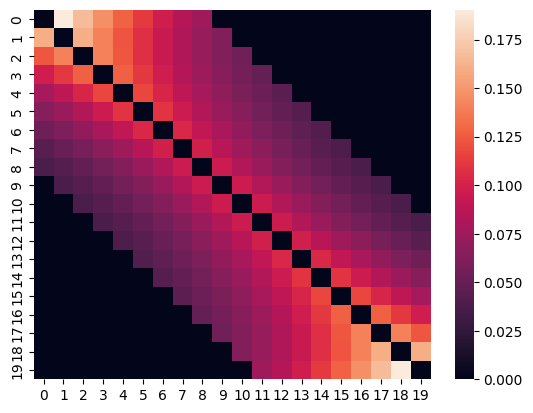

In [39]:
cf = create_context_coeff_matrix(ctx_len=8, seq_len=20)
sns.heatmap(cf)
plt.show()

In [7]:
a = np.array([[2, 3], [4, 5]])

b = np.array([0, 0, 1, 0])

np.take_along_axis(a, b[:, None], axis=0)

array([[2, 3],
       [2, 3],
       [4, 5],
       [2, 3]])

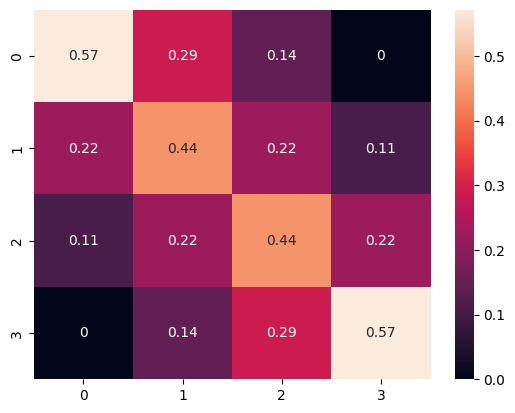

In [8]:
cf = create_context_coeff_matrix(ctx_len=2, seq_len=4)
sns.heatmap(cf, annot=True)
plt.show()

In [9]:
np.array([[1, 1], [2, 2], [3, 3], [4, 4]])[None, ...]

array([[[1, 1],
        [2, 2],
        [3, 3],
        [4, 4]]])

In [10]:
tensor = jnp.array([
    [[1, 1], [2, 2], [3, 3], [4, 4]],
    # 0.57 * [1, 1] + 0.29 * [2, 2] + 0.14 * [3, 3] + 0    * [4, 4] = [1.57, 1.57]
    # 0.22 * [1, 1] + 0.44 * [2, 2] + 0.22 * [3, 3] + 0.11 * [4, 4] = [2.2, 2.2]
    # 0.11 * [1, 1] + 0.22 * [2, 2] + 0.44 * [3, 3] + 0.22 * [4, 4] = [2.75, 2.75]
    # 0    * [1, 1] + 0.14 * [2, 2] + 0.29 * [3, 3] + 0.57 * [4, 4] = [3.43, 3.43]
    [[1, 2], [3, 4], [5, 6], [8, 9]],
])  # (D, W, T)
# (W, W)

# res = np.einsum('hwk,wj->hwk', tensor, cf)
# res = np.dot(tensor, cf[None, ...])
# res = fftconvolve(tensor[:, None, :, :], cf[::-1][None, :, :, None], mode='valid', axes=2)
res = jnp.sum(tensor[:, None, :, :] * cf[None, :, :, None], axis=2)
# res = res.sum(axis=2)
res.shape, res

((2, 4, 2),
 Array([[[1.5714287, 1.5714287],
         [2.2222223, 2.2222223],
         [2.777778 , 2.777778 ],
         [3.4285717, 3.4285717]],
 
        [[2.142857 , 3.1428573],
         [3.5555556, 4.555556 ],
         [4.7777777, 5.777778 ],
         [6.4285717, 7.428572 ]]], dtype=float32))

In [11]:
res.reshape(-1, res.shape[-1])

Array([[1.5714287, 1.5714287],
       [2.2222223, 2.2222223],
       [2.777778 , 2.777778 ],
       [3.4285717, 3.4285717],
       [2.142857 , 3.1428573],
       [3.5555556, 4.555556 ],
       [4.7777777, 5.777778 ],
       [6.4285717, 7.428572 ]], dtype=float32)

In [12]:
key = jax.random.key(42)
tensor = jax.random.normal(
    key=key,
    shape=(2000, 500, 10),
)  # (D, W, T)
cf = create_context_coeff_matrix(ctx_len=5, seq_len=500)
print(tensor.shape, cf.shape)

def foo(x, y):
    return jnp.sum(x[:, None, :, :] * y[None, :, :, None], axis=2)

print('Testing base function:')
%timeit foo(tensor, cf)
# print('Testing vectorized function:')
# vf = jax.vmap(foo)
# %timeit vf(tensor[:, None, :, :], cf[None, :, :, None])
print('Testing jit-compilation on base function:')
jf = jax.jit(foo)
%timeit jf(tensor, cf)
# print('Testing jit-compilation on vectorized function:')
# jvf = jax.jit(vf)
# %timeit jvf(tensor, cf)
print('Testing inline function:')
%timeit jnp.sum(tensor[:, None, :, :] * cf[None, :, :, None], axis=2)

(2000, 500, 10) (500, 500)
Testing base function:
2.81 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Testing jit-compilation on base function:
The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached.
2.31 s ± 1 s per loop (mean ± std. dev. of 7 runs, 10 loops each)
Testing inline function:
11.9 s ± 321 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
@jax.jit
def _norm(x: jax.Array):
    assert np.any(np.isnan(x))
    # take x+ = max(x, 0) element-wise (perform projection on positive simplex)
    x = jnp.maximum(x, jnp.zeros_like(x))
    # normalize values in non-zero rows to 1 (mapping from the positive simplex to the unit simplex)
    norm = x.sum(axis=0)
    x = jnp.where(norm > 1e-12, x / norm, x)
    return x

_norm(
    jnp.array([
        [1, -1, 1, 2],
        [1, 3, -4, 3],
    ])
)

Array([[0.5, 0. , 1. , 0.4],
       [0.5, 1. , 0. , 0.6]], dtype=float32)

In [16]:
indices = np.array([0, 0, 0, 1, 2, 1, 3, 2])
values = np.array([[0.1, 0.3], [2, 4], [5, 2], [1, 0]])

# Create a one-hot encoding of the indices
one_hot_indices = np.eye(indices.max() + 1)[indices]

# Multiply the one-hot encoding by the values
multiplied_values = values * one_hot_indices.sum(axis=0)[:, None]

print(multiplied_values)  # Output: [0.2, 4, 0.1, 10]

[[ 0.3  0.9]
 [ 4.   8. ]
 [10.   4. ]
 [ 1.   0. ]]


In [119]:
class ContextTopicModelDebug():
    """
    Topic model which uses local context of words
    """

    def __init__(
            self,
            ctx_len: int,
            max_len: int,
            vocab_size: int,
            n_topics: int = 10,
            reg_list: list = None,
            eps: float = 1e-12,
    ):
        """
        Args:
            ctx_len: one-sided context size
            max_len: max length of a document, W_d
            vocab_size: corpus vocabulary size, W
            n_topics: number of topics, T
            regularizations: list of regularizations (see `add_regularization` method)
            eps: parameter set for balance between numerical stability and precision

        Note:
            - Total context of a word on `i`-th index is ctx_len words to the left,\\
            `ctx_len` words to the right, and the word itself
            - All documents should be padded to `max_len` length
        """
        self.ctx_len = ctx_len
        self.seq_len = max_len
        self.n_topics = n_topics
        self.vocab_size = vocab_size
        self._eps = eps

        self._context_coeffs = self._create_context_coeff_matrix()

        self._regularizations = dict()
        if reg_list is not None:
            for reg in reg_list:
                self.add_regularization(reg)

    def _norm(self, x: jax.Array) -> jax.Array:
        assert jnp.any(~jnp.isnan(x)), jnp.sum(x)
        # take x+ = max(x, 0) element-wise (perform projection on positive simplex)
        x = jnp.maximum(x, jnp.zeros_like(x))
        # normalize values in non-zero rows to 1 (mapping from the positive simplex to the unit simplex)
        norm = x.sum(axis=0)
        x = jnp.where(norm > self._eps, x / norm, jnp.zeros_like(x))
        return x

    def _create_context_coeff_matrix(self) -> jax.Array:
        gamma = 1 / self.ctx_len

        # construct tril matrix (suffix context)
        tril_matrix = np.zeros((self.seq_len, self.seq_len))
        for i in np.arange(1, self.ctx_len + 1):
            tril_matrix[np.arange(i, self.seq_len), np.arange(self.seq_len - i)] = gamma * (1 - gamma) ** i

        # contstruct full matrix (self + prefix + suffix context)
        full_matrix = tril_matrix + tril_matrix.T # + np.eye(tril_matrix.shape[0]) * gamma 

        # normalize weights and transpose
        full_matrix /= full_matrix.sum(axis=0)
        full_matrix = full_matrix.T
        return jnp.array(full_matrix)

    def add_regularization(self, reg, tag: str = None):
        """
        Add `reg` regularization to the model with `tag` identifier \\
        Note:
        - `reg` has to be a child of base `Regularization` class
        - `tag` will use the name of the class by default
        """
        if tag is None:
            tag = reg.__name__
        if not isinstance(reg, Regularization):
            raise TypeError(f'Regularization [{tag}] has to be a subclass of Regularization class')

        try:
            self._regularizations[tag] = jax.grad(reg)
        except Exception:
            raise

    def _compose_regularizations(self):
        regs = self._regularizations.values()
        sum_reg = lambda x: sum([1.0, ] + [reg(x) for reg in regs])
        return jax.jit(jax.grad(sum_reg))

    def fit(self, data: jax.Array, max_iter: int = 1000, tol: float = 1e-3, seed: int = 0, test_data=None):
        """
        Args:
            data: matrix of shape (D, W_d), containing tokenized words of each document
            max_iter: max number of iterations
            tol: early stopping threshold
            seed: random seed
        """
        key = jax.random.key(seed)
        self.phi = jax.random.uniform(
            key=key,
            shape=(self.vocab_size, self.n_topics),
        )  # (W, T)
        self.n_t = jnp.full(
            shape=(self.n_topics, ),
            fill_value=jnp.sum(data, dtype=jnp.float32) / self.n_topics,
        )  # (T, )
        grad_regularization = self._compose_regularizations()

        self.phi = self._norm(self.phi)
        t_cur = time.time()
        for it in range(max_iter):
            # Calculate phi' (words -> topics) matrix (phi with old p_{ti})
            print(np.array(self.phi).shape, np.array(self.n_t).shape, f'{time.time() - t_cur:.01f}')
            phi_hatch = self._norm(self.phi.T * self.n_t[:, None]).T  # (W, T)
            print(np.array(phi_hatch).shape, f'{time.time() - t_cur:.01f}')

            # Create theta (documents -> topics) matrix
            # We can interpret phi as a bunch of embeddings for words,
            # thus creating tensor of embeddings of words in documents
            # and calculating context (document embedding), based on this
            data_emb = jnp.take_along_axis(phi_hatch[None, ...], indices=data[..., None], axis=1)  # (D, W_d, T)
            print(np.array(data_emb)[:, None, :, :].shape, self._context_coeffs[::-1][None, :, :, None].shape, f'{time.time() - t_cur:.01f}')
            theta_new = jnp.sum(
                data_emb[:, None, :, :] * self._context_coeffs[None, :, :, None],
                axis=2,
            )  # (D, W_d, T)
            print(np.array(theta_new).shape, f'{time.time() - t_cur:.01f}')
            # Now we see each context window as a new document, I - number of context documents
            theta_new = theta_new.reshape(-1, theta_new.shape[-1])  # (I, T)

            # Update p_{ti} - topic probability distribution for i-th context
            data_emb = jnp.take_along_axis(self.phi[None, ...], indices=data[..., None], axis=1)  # (D, W_d, T)
            print(np.array(data_emb).shape, f'{time.time() - t_cur:.01f}')
            p_ti = data_emb.reshape(-1, data_emb.shape[-1])  # (I, T)
            p_ti = self._norm((p_ti * theta_new).T).T  # (I, T)
            print(np.array(p_ti).shape, f'{time.time() - t_cur:.01f}')

            # Update n_{t} - topic probability distribution
            self.n_t = jnp.sum(p_ti, axis=0)  # (T, )
            print(np.array(self.n_t).shape, f'{time.time() - t_cur:.01f}')

            # Update phi (words -> topics) matrix (phi with new p_{ti})
            indices = data.flatten()  # (I, )
            phi_new = jnp.add.at(jnp.zeros_like(self.phi), indices, p_ti, inplace=False)  # (W, T)
            print(np.array(phi_new).shape, f'{time.time() - t_cur:.01f}')
            phi_new += self.phi * grad_regularization(self.phi)  # (W, T)
            print(np.array(phi_new).shape, f'{time.time() - t_cur:.01f}')
            phi_new = self._norm(phi_new)  # (W, T)

            diff_norm = jnp.linalg.norm(phi_new - self.phi)
            theta_doc = theta_new.reshape(data.shape + (-1, )).sum(axis=1)
            res_diff_norm = jnp.exp(-jnp.sum(test_data * jnp.log(theta_doc @ phi_new.T + self._eps)) / (data.shape[0] * data.shape[1]))
            print(f'Iteration [{it}/{max_iter}], update diff norm: {diff_norm:.04f}, perplexity: {res_diff_norm:.04f}')
            self.phi = phi_new
            if diff_norm < tol:
                break

In [120]:
maxlen = 100
dataset = ArticlesDataset(df, maxlen=maxlen)
len(dataset)

18846

In [ ]:
bow = CountVectorizer(
    preprocessor=lambda x: ' '.join(ArticlesDataset.preprocess_text(x)),
    tokenizer=word_tokenize,
    vocabulary=dataset.vocab,
).fit_transform(df.text.to_list())
bow = jnp.array(bow.todense())
# bow /= bow.sum(axis=1)[:, None]
bow.shape

/Users/diyakovilya/Library/Caches/pypoetry/virtualenvs/topic-modelling-attention-srLx0cG6-py3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/diyakovilya/Library/Caches/pypoetry/virtualenvs/topic-modelling-attention-srLx0cG6-py3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


(18846, 107673)

In [117]:
bow

Array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [121]:
model = ContextTopicModelDebug(
    ctx_len=100,
    max_len=maxlen,
    vocab_size=len(dataset.vocab),
    n_topics=10,
)
model.fit(dataset.data, test_data=bow)

(107673, 10) (10,) 0.0
(107673, 10) 0.0
(18846, 1, 100, 10) (1, 100, 100, 1) 0.0
(18846, 100, 10) 1.0
(18846, 100, 10) 1.1
(1884600, 10) 1.1
(10,) 1.1
(107673, 10) 1.2
(107673, 10) 1.2
Iteration [0/1000], update diff norm: 0.4974, perplexity: 5963.5566
(107673, 10) (10,) 8.2
(107673, 10) 8.2
(18846, 1, 100, 10) (1, 100, 100, 1) 8.2
(18846, 100, 10) 8.8
(18846, 100, 10) 8.8
(1884600, 10) 8.9
(10,) 8.9
(107673, 10) 9.0
(107673, 10) 9.0
Iteration [1/1000], update diff norm: 0.0717, perplexity: 5955.3384
(107673, 10) (10,) 15.6
(107673, 10) 15.6
(18846, 1, 100, 10) (1, 100, 100, 1) 15.7
(18846, 100, 10) 16.3
(18846, 100, 10) 16.3
(1884600, 10) 16.3
(10,) 16.3
(107673, 10) 16.4
(107673, 10) 16.4
Iteration [2/1000], update diff norm: 0.0862, perplexity: 5840.1572
(107673, 10) (10,) 23.2
(107673, 10) 23.2
(18846, 1, 100, 10) (1, 100, 100, 1) 23.2
(18846, 100, 10) 23.8
(18846, 100, 10) 23.9
(1884600, 10) 23.9
(10,) 23.9
(107673, 10) 24.0
(107673, 10) 24.0
Iteration [3/1000], update diff norm: 

In [107]:
# maxlen = 500, context = 10
topk = jnp.argsort(model.phi, axis=0, descending=True)[:10, :].T  # (T, W_{top})
reverse_vocab = {value: key for key, value in dataset.vocab.items()}

for t in topk:
    print('\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

year	gun	law	government	u	bike	state	israeli	new	american

window	x	use	system	problem	get	need	anyone	drive	file

edu	writes	c	article	subject	apr	cc	news	andrew	uiuc

line	organization	subject	posting	host	nntp	university	distribution	ca	x

one	would	people	think	know	like	time	say	thing	get

thanks	e	please	mail	email	help	advance	p	u	address

com	writes	subject	article	apr	org	gov	netcom	nasa	access

PAD	ryerson	ryevm	keith	sola	employer	acps	tmi	teddy	polytechnical

game	team	player	year	win	last	v	co	play	pitt

PAD	rainer	elin	hochreiter	eeam	keith	excepted	omission	bye	donoghue



In [122]:
# maxlen = 500, context = 100

topk = jnp.argsort(model.phi, axis=0, descending=True)[:10, :].T  # (T, W_{top})
reverse_vocab = {value: key for key, value in dataset.vocab.items()}

for t in topk:
    print('\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

edu	posting	nntp	article	host	writes	subject	organization	line	com

would	one	think	know	people	like	thing	writes	make	even

x	window	line	subject	organization	c	file	problem	version	program

god	subject	line	christian	people	u	may	organization	say	one

com	subject	organization	line	article	writes	gov	apr	distribution	space

line	edu	subject	organization	drive	university	system	computer	card	e

edu	c	writes	article	university	subject	state	line	organization	apr

edu	game	line	organization	subject	year	c	university	ca	last

PAD	thanks	line	subject	organization	university	anyone	please	advance	mail

car	one	v	like	would	get	new	power	line	good



In [29]:
# maxlen = 100, context = 20

topk = jnp.argsort(model.phi, axis=0, descending=True)[:10, :].T  # (T, W_{top})
reverse_vocab = {value: key for key, value in dataset.vocab.items()}

for t in topk:
    print('\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

mr	one	also	time	first	uk	UNK	PAD	ad	sale

said	UNK	PAD	ad	sale	boost	time	warner	profit	quarterly

PAD	UNK	ad	sale	boost	time	warner	profit	quarterly	u

bn	said	UNK	PAD	ad	sale	boost	time	warner	profit

year	UNK	PAD	ad	sale	boost	time	warner	profit	quarterly

said	UNK	PAD	ad	sale	boost	time	warner	profit	quarterly

said	game	UNK	PAD	ad	sale	boost	time	warner	profit

said	last	year	UNK	PAD	ad	sale	boost	time	warner

u	would	year	film	people	UNK	PAD	ad	sale	boost

new	said	UNK	PAD	ad	sale	boost	time	warner	profit



In [32]:
# maxlen = 500, context = 20

topk = jnp.argsort(model.phi, axis=0, descending=True)[:10, :].T  # (T, W_{top})
reverse_vocab = {value: key for key, value in dataset.vocab.items()}

for t in topk:
    print('\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

mr	also	one	time	uk	people	best	told	first	get

said	would	company	player	could	time	UNK	PAD	ad	sale

PAD	UNK	ad	sale	boost	time	warner	profit	quarterly	u

said	bn	mr	u	also	company	one	last	government	sale

year	u	game	last	first	mr	film	people	two	make

said	mr	year	number	also	u	UNK	PAD	ad	sale

said	people	u	home	time	could	UNK	PAD	ad	sale

PAD	UNK	ad	sale	boost	time	warner	profit	quarterly	u

would	mr	people	could	year	say	two	world	labour	u

said	new	year	would	market	people	time	could	company	firm



In [1]:
# maxlen = 500, context = 100

topk = jnp.argsort(model.phi, axis=0, descending=True)[:10, :].T  # (T, W_{top})
reverse_vocab = {value: key for key, value in dataset.vocab.items()}

for t in topk:
    print('\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

NameError: name 'jnp' is not defined